<a href="https://colab.research.google.com/github/easyhardhoon/deep_learning_frameworks/blob/main/Pytorch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#비지도 학습

데이터 학습의 종류 : 지도 학습, 비지도 학습

⏰비지도 학습

    결과물이라고 할 수 있는 출력을 미리 제공하지 않고 
    
    AI가 입력 세트에서 패턴과 상관관계를 찾아내야 하는 머신러닝 알고리즘

    데이터 자체가 부족하거나 훈련 데이터를 수집하기에 비용이 너무 많이 들 때 사용

    레이블이 지정되지 않은 데이터를 처리하고,

    사용자가 보다 복잡한 처리 작업을 수행할 수 있도록 한다

⏰비지도 학습의 구성 요소

✅클러스터링 알고리즘 

    군집화 알고리즘. 분류되지 않은 데이터에서 구조나 패턴을 찾는 데에 도움을 준다. 
    미가공 데이터들을 일련의 특징으로 클러스터(그룹)으로 정렬시킨다.

✅잠재 변수 모델(Latent variable models)

    데이터 단순화 작업. 전처리 단계에서 큰 도움을 준다.

    차원 축소 기법으로 데이터 세트에서 그 특징의 수를 줄이거나 데이터 세트를 여러 구성요소로 분할함으로써

    데이터를 단순화시키는 데에 기여한다





✅ AutoEncoder

    비지도 학습의 일종.

    원래의 입력 데이터의 압축된 지식표현을 만들도록 병목(bottlenack)을 두는 신경망 

    레이블이 없는 데이터셋인 입력데이터 x를 가지고 

    입력 데이터를 재건한 출력 값 x^을 만든다

    이렇게 자기자신의 값을 정답으로 쓰기 때문에 자기지도학습 이라고도 한다.

    ex) 2차원(x1,x2)를 전달해야하는데 용량이 부족하다.

    그런데 점을 찍어보니 x2는 x1의 거의 2배에 근사하다.

    이 관측을 바탕으로 우리는 x1 데이터만 전송한 후, 전송받은 곳에서 2배를 해서 x2값을  구할 수 있다. 

    약간의 정보손실이 있지만, 네트워크 트래픽은 크게 줄었다. 

▶ 병목(bottlenack) 

    전체 네트워크를 통과 할수 있는 정보의 양을 제한하여 입력 데이터의 학습된 압축을 이끌어 낸다.

    Hidden layer의 뉴런 수를 input layer & output layer의 뉴런수보다 적게 할 수 있습니다.

    (autoencoder의 특성상 input과 output의 뉴런수는 같다)

더 상세한 AutoEncoder에 대한 설명은 아래 링크를 참고

https://hyen4110.tistory.com/37

✅ k평균 알고리즘

(클로스터링 알고리즘의 한 예시입니다)


    가깝게 위치하는 데이터를 비슷한 특성을 지닌 데이터로 여기고 같은 군집으로 군집화한다.

    즉 데이터를 k개의 군집으로 묶는 알고리즘이다.

    (기본적으로 머신러닝의 비지도학습에 속한다)

**autoencoder의 장점**

원래 있던 정보를 압축하여 사용. 차원축소가 가능 ,레이블 없이 이미지를 예측,분류가 가능


**비지도 학습의 흐름**

비지도 학습의 예측,분류 방법이 바로 autoencoder의 hidden layer의 병목의 결과인 latent variable을 

군집화 알고리즘( ex) k-means알고리즘) 에 넣는 것이다. 

**아래 사진 참조**



Mounted at /gdrive


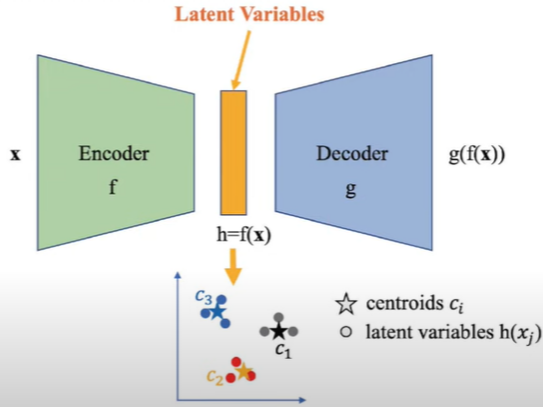

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
from IPython.display import Image
Image('/gdrive/My Drive/ex0.png')

이렇게 비지도 학습은 보통 

오토인코더 + 군집화(clustering)알고리즘으로 구성된다. 

**이제 비지도 학습의 코드 구현입니다**

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment
#재배열(재조정)의 한 방법. 0은 '0'그룹, 1은 '1'그룹으로 정의해주는 과정. 
#accuracy산출을 위해 필요한 작업. 자세한 건 다음 코드에서


from sklearn.manifold import TSNE #고차원 데이터를 저차원으로 낮춰주는 함수
from matplotlib import pyplot as plt #시각화

**지도학습은 분류(classification)**

레이블을 가지고 학습, 예측을 한다.

0이라는 레이블은 숫자 0.

5라는 숫자는 5라는 레이블

**비지도학습은 군집화(clustering)**

1,2,3조로 만든다. 그래서 숫자 1이 "2" 레이블로 들어갈 수 있다.

만약 숫자 1이 모두 "1"에 들어가있고 2가 모두 "2"에 들어가 있다면, 이를 좋은 모델이라 할 수 있다.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")
#이 작업을 위해 작업 수행을 cpu에서 gpu로 변경하였습니다. (런타임 수정 )

cpu is available


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
#데이터 불러오기
import torchvision
batch_size = 128
num_clusters = 10 #군집의 갯수
latent_size = 10 #임의로 정하면 됩니다. 군집수랑 같아야할 필요 없다

trainset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data/', download = True, train=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle= True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)

In [10]:
#모델 정의
class Flatten(torch.nn.Module): #인코더에서
  def forward(self,x):
    batch_size = x.shape[0]
    return x.view(batch_size,-1) #단순히 2차원으로 펴주는 함수입니다
class DeFlatten(nn.Module): #디코더에서
  def __init__(self,k):
    super(DeFlatten,self).__init__() #이렇게 init매서드를 쓸거면 super로 부모 클래스 초기화 필수
    self.k = k
  def forward(self,x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0], self.k, feature_size,feature_size) #아무튼 다시 원래차원으로 펴주는 함수입니다

class Kmeans(nn.Module): #kmeans 구현은 다양합니다.
  def __init__(self,num_clusters, latent_size):
    super(Kmeans,self).__init__()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.num_clusters = num_clusters
    self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device)) 
    #centroid는,지도학습의 가중치 매개변수와 같은 개념으로 볼 수 있을 것 같습니다.
  def argminl2distance(self,a,b):
      return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0) #가장 가까운(거리) 점
  def forward(self,x): #업데이트
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(self.num_clusters,-1) #모두를 한번에
      assign = self.argminl2distance(h,self.centroids)
      y_assign.append(assign.item())
    return y_assign, self.centroids[y_assign]


In [11]:
#위 사진의 개념으로 이해.
class Encoder(nn.Module):
  def __init__(self,latent_size):
    super(Encoder,self).__init__()
    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1,k,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(k,2*k,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(2*k,4*k,3,stride=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(1024,latent_size),
        nn.ReLU()
    )
  def forward(self,x):
    return self.encoder(x)
class Decoder(nn.Module):
  def __init__(self,latent_size):
    super(Decoder,self).__init__()
    k=16
    self.decoder = nn.Sequential(
        nn.Linear(latent_size,1024),
        nn.ReLU(),
        DeFlatten(4*k),
        nn.ConvTranspose2d(4*k,2*k,3,stride=1), #Conv2d의 반대개념이라 생각
        nn.ReLU(),
        nn.ConvTranspose2d(2*k,k,3,stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(k,1,3,stride=2,output_padding=1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.decoder(x)
#인코더와 디코더를 한번에 만들수도 있다. 오토인코더

In [12]:
#클러스터링 정확도 함수 정의
def cluster_acc(y_true,y_pred):
  y_true = np.array(y_true) # y_true은 정답 레이블입니다.
  y_pred = np.array(y_pred)
  D = max(y_pred.max(), y_true.max()) +1
  w = np.zeros((D,D), dtype=np.int64) # D * D 크기의 행렬을 생성한다. 
  for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] +=1 #매칭이 되면 1이 계속 누적
  ind = linear_assignment(w.max()-w) #위의 .w행렬을 토대로, 1은 "1"로 가도록. 재조정을 하는 함수의 의미였습니다.
  return sum([w[i,j] for i,j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size #이제 이 재조정 값으로 정확도를 산출하고 리턴합니다

def evaluation(testloader, encoder, kmeans, device):
  predictions = []
  actual = []
  with torch.no_grad():
    for images,labels in testloader:
      inputs = images.to(device)
      labels = labels.to(device)
      latent_var = encoder(inputs) #encoder의 결과가 latent_var인 모습입니다
      y_pred, _ = kmeans(latent_var) #latent_Var을 kmeans알고리즘에 넣어서 y_prediction을 구한 모습입니다.
      predictions +=y_pred #y_pred들을 더해 prediction을 산출합니다.  
      actual += labels.cpu().tolist() #진짜 값(label)은 이렇게 정확도를 평가할때만 잠깐 사용합니다. 
    return cluster_acc(actual, predictions) #위에서 구한 cluster_acc에 정답값과 예측값을 인자로 넣어 최종 정확도를 산출합니다.

**위 코드에서**

실제 학습에서는 정답 레이블이 사용되지 않다가, 군집화의 정확도를 평가할때만 정답 레이블을 끼워 산출하는 모습입니다.

In [13]:
#손실함수 및 최적화 방법 정의
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters,latent_size).to(device)

criterion1 = torch.nn.MSELoss() #오토인코더에 쓰일 loss
criterion2 = torch.nn.MSELoss() #클러스터의 centroid에 쓰일 loss
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(kmeans.parameters()), lr=1e-3) 
#모델이 여러개면 이렇게 리스트의 합으로 넣는다
#이렇게 encoder, decoder, kmeans에서 각각의 가중치 파라미터들이 필요하고 이 값들이 핵심임을 알 수 있다.

In [ ]:
#학습하기
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05
for ep in range(20): #원래는 300이지만 20까지만 하겠습니다
  if (ep>T1) and (ep<T2):
    alpha = lam * (ep-T1)/(T2-T1) #조금조금씩 에폭마다 alpha가 증가하도록 설계
  elif ep>= T2:
    alpha = lam
  else:
    alpha = lam / (T2-T1)
  running_loss = 0.0
  for images, _ in trainloader: #정답 레이블을 쓰지 않는 모습. 비지도학습이기 때문입니다.
    inputs = images.to(device)
    optimizer.zero_grad()
    latent_var = encoder(inputs)
    _, centroids = kmeans(latent_var.detach())
    outputs = decoder(latent_var)
  #여기서부터!!
    l_rec = criterion1(inputs,outputs) #비교대상에 주목. 
    #지도학습에서는 output과 label을 비교했다. 예측값과 정답값을 비교하였다.
    l_clt = criterion2(latent_var, centroids)
    loss = l_rec + alpha*l_clt #이렇게 encoder, kmeans의 loss를 모두 고려하기 위해 alpha를 도입했다
    #alpha를 도입하지 않으면 불균형이 생길 수 있다. alpha는 작게 해주는게 일반
    #아예 따로 loss를 구해도 되긴 한다. 
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  avg_loss = running_loss / len(trainloader)

  if ep % 10 == 0:
    testacc = evaluation(testloader, encoder, kmeans, device)
    print('[%d] Train loss : %.4f, Test Accuracy : %.3f' %(ep, avg_loss, testacc))
  if avg_loss < ls:
    ls = avg_loss
    torch.save(encoder.state_dict(),'./Users\이지훈\pytorch\dkm_en.pth')
    torch.save(decoder.state_dict(),'./Users\이지훈\pytorch\dkm_de.pth')
    torch.save(kmeans.state_dict(),'./Users\이지훈\pytorch\dkm_clt.pth')



In [ ]:

#데이터 불러오기
encoder.load_state_dict(torch.load('./Users\이지훈\pytorch\dkm_en.pth'))
decoder.load_state_dict(torch.load('./Users\이지훈\pytorch\dkm_de.pth'))
kmeans.load_state_dict(torch.load('./Users\이지훈\pytorch\dkm_clt.pth'))

<All keys matched successfully>

In [ ]:
predictions = []
actual  =[]
latent_features = []
with torch.no_grad():
  for images, labels in testloader:
    inputs = images.to(device)
    labels = labels.to(device)
    latent_var = encoder(inputs)
    y_pred, _ = kmeans(latent_var)

    predictions += y_pred
    latent_features += latent_var.cpu().tolist()
    actual += labels.cpu().tolist()
print(cluster_acc(actual,predictions))
#에폭을 늘리면 정확도가 증가할 것이다

0.4557


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


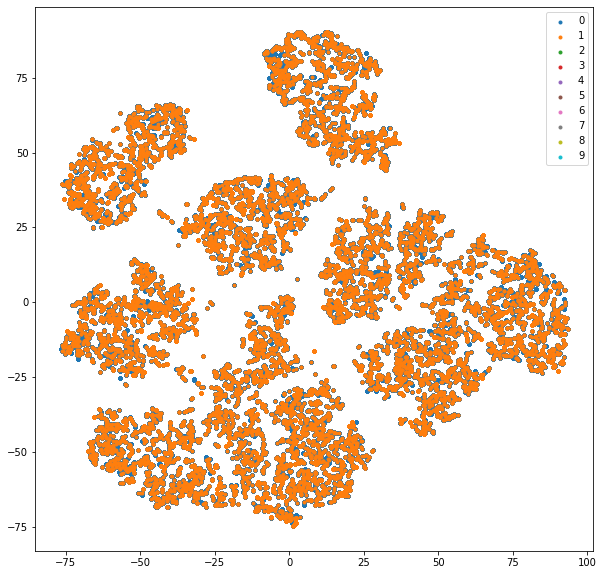

In [ ]:
tsne = TSNE(n_components = 2, random_state= 0) #2차원으로 낮추고 그래프를 도식화해보겠다.
cluster = np.array(tsne.fit_transform(np.array(latent_features)))
actual = np.array(actual)

plt.figure(figsize=(10,10))
mnist = range(10)
for i, label in zip(range(10),mnist):
    idx = np.where(actual==i)
    plt.scatter(cluster[idx,0], cluster[idx,1], marker='.', label=str(label))
plt.legend()
plt.show()

#위 그래프에서

epoch을 높이면 색깔마다(0~9) 군집에 잘 모여있는 것을 확인할 수 있다. 

근데 CPU 쓰든 GPU 쓰든 계산이 너무 느리다...

**비지도 학습의 흐름**

✅ cluser_acc(y_true,y_pred)

    비지도 학습을 통해 구한 예측값(군집 형태로 이루어져 있음)과 정답 레이블 값을 인자로 받아서, 
    
    예측값의 1을 군집"1" 에 보내고 2를 "2"에 보내는, "군집 재조정"을 한 뒤

    재조정된 값으로 학습의 정확도를 리턴합니다


✅kmeans(num_clusters, latent_size)

    num_clusters(군집수) ^ latent_size(kmeans 기준 입력의 크기) 행렬의 센트로이드(파라미터)를 생성합니다.

    그리고 데이터를 최소 거리 기준으로 군집화하고, 결과값과 센트로이드(kmeans에 쓰이는 파라미터)를 리턴합니다


✅기본 흐름

    latent_val = encoder(input)   -------> 최초 input을 인코더에 넣어 latent_val을 구한다

    y_pred, centroids = kmeans(latent_var.detach())  ------> latent_val을 kmeans에 넣어 예측값과 매개변수값(파라미터)을 구한다

    outputs = decoder(latent_var) -------> latent_val을 디코더에 넣어 output을 구한다

    l_rec = criterion1(inputs, outputs) -----> autoencoder의 오차를 구한다

    l_clt = criterion2(latent_var, centroids) -----> kmeans 알고리즘의 오차를 구한다.

    loss = l_rec + alpha*l_clt -----> 두 예비 loss를 조합하여 최종 loss를 구한다

    loss.backward() -----> 스칼라 loss 기준 backward를 구해 미분값을 구한다

    optimizer.step() ----> 원하는 방향으로 매개변수를 갱신한다.



**한가지 걸리는 점**

criterion2(latent_val, centroid)에서, 왜 "값"과 "파라미터"를 비교해서 오차함수를 구할까

✅**centroid**는

중심점입니다. 학습이 되면서 이 중심점이 계속 수정되는 것입니다.

즉, centroid는 군집화 알고리즘에서 학습이 될 때마다 업데이트가 되고, 이 값을 최적화시키는 것입니다. 

**따라서 centroid는 파라미터이고 동시에 값입니다.**

⚡지도학습에서는, criterion(ouput, label) 을 통해 예측값과 정답레이블을 비교한 다음

이 loss를 통해 layer의 가중치 매개변수의 값을 최적화하였고

⚡비지도학습에서는, criterion(input, output)을 통해 입력데이터값과 학습을 통해 스스로 얻은 출력값을 비교합니다

이 loss를 통해 인코더,디코더,kmeans의 가중치 매개변수의 값을 최적화하였습니다

**비지도학습에서는, 정답 레이블을 주지 않습니다. 단지 비지도학습의 최종 정확도를 구할때 쓰일 뿐입니다**


#마치며

**비지도학습에 대한 추가개념 공부가 진행될 예정입니다**